In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import timeit
from tqdm import tqdm
import os
import gc

In [2]:
import torch
from torch import nn
from typing import Tuple
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import pandas as pd

is_kaggle = os.path.exists('/kaggle')
print('Using Kaggle:', is_kaggle)

Using Kaggle: False


In [3]:
img_size = 64
lr = 2e-4
beta1 = 0.5 # za adam optimizator
checkpoint_frequency = 10
random_seed = 42
num_workers = 8

In [18]:
params = {
    'MNIST': {
        'num_classes' : 10, 
        'embedding_dim' : 5,
        'num_channels' : 1, 
        'data_path' : '/kaggle/input/mnist-digit-recognizer/train.csv' 
            if is_kaggle else './datasets/mnist/train.csv',
        'input_vector_dim' : 20,
        'num_epochs': 50,
        'batch_size' : 256,  
        'feature_map_dim' : 64,
        'reconstruction_weight' : 5,
        
    },
    'animals': {
        'num_classes' : 3, 
        'embedding_dim' : 5,
        'num_channels' : 3, 
        'data_path' : '/kaggle/input/afhq-512' 
            if is_kaggle else './datasets/afhq/',
        'input_vector_dim' : 100,
        'reconstruction_weight' : 5,
        'num_epochs': 100,
        'batch_size' : 128, 
        'feature_map_dim' : 96
    },
    'celeba': {
        'num_classes' : 1, 
        'embedding_dim' : 1,
        'num_channels' : 3, 
        'data_path' : '/kaggle/input/celeba' 
            if is_kaggle else './datasets/img_align_celeba/',
        'input_vector_dim' : 20,
        'reconstruction_weight' : 0,
        'num_epochs': 30,
        'batch_size' : 256, 
        'feature_map_dim' : 64
    },
    'cat_and_dogs': {
        'num_classes' : 2, 
        'embedding_dim' : 5,
        'num_channels' : 3, 
        'data_path' : '/kaggle/input/cat_and_dogs' 
            if is_kaggle else './datasets/cats_dogs/',
        'input_vector_dim' : 100,
        'reconstruction_weight' : 5,
        'num_epochs': 40,
        'batch_size' : 64, 
        'feature_map_dim' : 96
    }
}

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple

class MNISTDataset(Dataset):
    def __init__(self, path: str):
        df = pd.read_csv(path)
        self.labels = torch.from_numpy(df.iloc[:, 0].values.astype(int))
        self.images = torch.tensor(df.iloc[:, 1:].values.reshape(df.shape[0], 1, 28, 28), dtype=torch.float32) / 255.0
        
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomRotation(30),     
            transforms.RandomCrop((64, 64), padding=4) 
        ])
        
    def __len__(self) -> int:
        return self.labels.shape[0]
    
    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = self.images[i]
        image = self.transform(image)
        return image, self.labels[i]



In [7]:
datasetMNIST = MNISTDataset(params['MNIST']['data_path'])
dataloader_mnist = DataLoader(datasetMNIST, params['MNIST']['batch_size'], num_workers=4, shuffle=True)

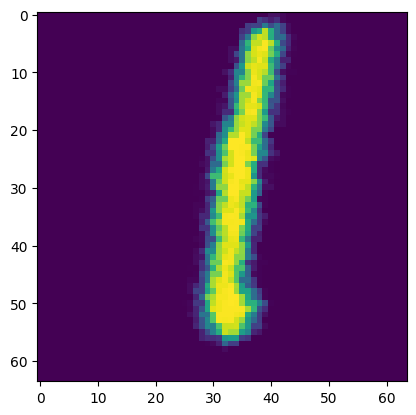

In [8]:
labels = []
for x in range(100):
    # print(datasetMNIST[x][0].shape)
    labels.append(datasetMNIST[x][1])
    
data = datasetMNIST[0]
#data_normalized = (data[0] - data[0].min()) / (data[0].max() - data[0].min()) ??

plt.imshow(data[0].permute((1, 2, 0)))

In [9]:
animals_dataset = ImageFolder(params['animals']['data_path'], 
                                transform= transforms.Compose([
                                transforms.Resize(img_size), 
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(*((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
                     ]))
print(animals_dataset.classes)

['cat', 'dog', 'wild']


In [10]:
celeba_dataset = ImageFolder(params['celeba']['data_path'], 
                                transform= transforms.Compose([
                                transforms.Resize(img_size), 
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(*((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
                     ]))

print(celeba_dataset.classes)

['img_align_celeba']


In [11]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_dim, channels, num_classes, embedding_dim):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        
        self.conv_1 = nn.Conv2d(channels + embedding_dim, feature_map_dim*2, 4, 2, 1, bias=False)
        self.conv_2 = nn.Conv2d(feature_map_dim*2, feature_map_dim*4, 4, 2, 1, bias=False) 
        self.conv_3 = nn.Conv2d(feature_map_dim*4, feature_map_dim*8, 4, 2, 1, bias=False) 
        self.conv_4 = nn.Conv2d(feature_map_dim*8, feature_map_dim*16, 4, 2, 1, bias=False) 
        self.conv_5 = nn.Conv2d(feature_map_dim*16, 1, 4, 1, 0, bias=False) 
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*16)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_image, label):

        emb = self.embedding(label)
        emb = emb.view(emb.shape[0], emb.shape[1], 1, 1)
        emb = emb.expand(emb.shape[0], emb.shape[1], img_size, img_size)
        input_with_emb = torch.cat([input_image, emb], dim=1)
        x = self.conv_1(input_with_emb)
    
        x = self.leaky_relu(x)
        
        x = self.conv_2(x)
        x = self.batch_norm_1(x)
        x = self.leaky_relu(x)
        
        x = self.conv_3(x)
        x = self.batch_norm_2(x)
        x = self.leaky_relu(x)
        
        x = self.conv_4(x)
        x = self.batch_norm_3(x)
        x = self.leaky_relu(x)
        
        x = self.conv_5(x)
        out = self.sigmoid(x)
        
        return out

In [12]:
discriminator = Discriminator(params['MNIST']['feature_map_dim'], params['MNIST']['num_channels'], params['MNIST']['num_classes'], params['MNIST']['embedding_dim']).to(device)
x = torch.randn(params['MNIST']['batch_size'],params['MNIST']['num_channels'], img_size, img_size).to(device)
mnist_y = torch.ones(params['MNIST']['batch_size'], dtype=torch.long).to(device)
discriminator_out = discriminator(x, mnist_y)
print(discriminator_out.size())

torch.Size([256, 1, 1, 1])


In [13]:
class Generator(nn.Module):
    def __init__(self, input_vector_dim, feature_map_dim, channels, num_classes, embedding_dim):
        super(Generator, self).__init__()

        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.convt_1 = nn.ConvTranspose2d(input_vector_dim + embedding_dim, feature_map_dim*16, 4, 1, 0, bias=False) 
        self.convt_2 = nn.ConvTranspose2d(feature_map_dim*16, feature_map_dim*8, 4, 2, 1, bias=False)
        self.convt_3 = nn.ConvTranspose2d(feature_map_dim*8, feature_map_dim*4, 4, 2, 1, bias=False)
        self.convt_4 = nn.ConvTranspose2d(feature_map_dim*4, feature_map_dim*2, 4, 2, 1, bias=False) 
        self.convt_5 = nn.ConvTranspose2d(feature_map_dim*2, channels, 4, 2, 1, bias=False) 
        
        self.relu = nn.ReLU()
        
        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)
        
        self.tanh = nn.Tanh()
        
        
    def forward(self, input, label):
        emb = self.embedding(label)
        emb = emb.view(emb.shape[0], emb.shape[1], 1, 1)
        input_with_emb = torch.cat([input, emb], dim=1)
        x = self.convt_1(input_with_emb)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        
        x = self.convt_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        
        x = self.convt_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        
        x = self.convt_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)
        
        x = self.convt_5(x)
        out = self.tanh(x)
        
        return out

In [14]:
generator = Generator(params['MNIST']['input_vector_dim'], params['MNIST']['feature_map_dim'], params['MNIST']['num_channels'], params['MNIST']['num_classes'], params['MNIST']['embedding_dim']).to(device)
noise = torch.randn(params['MNIST']['batch_size'], params['MNIST']['input_vector_dim'], 1, 1, device=device)
generated_output = generator(noise, mnist_y)
print(generated_output.size())

torch.Size([256, 1, 64, 64])


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

  2%|▏         | 1/50 [00:33<27:11, 33.30s/it]

Discriminator loss for epoch 1 : 0.7037

Discriminator real loss for epoch 1 : 0.7012

Discriminator fake loss for epoch 1 : 0.7062

Generator loss for epoch 1 : 2.2535


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

  4%|▍         | 2/50 [01:06<26:39, 33.32s/it]

Discriminator loss for epoch 2 : 0.6379

Discriminator real loss for epoch 2 : 0.6341

Discriminator fake loss for epoch 2 : 0.6417

Generator loss for epoch 2 : 2.0559


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

  6%|▌         | 3/50 [01:40<26:07, 33.35s/it]

Discriminator loss for epoch 3 : 0.5951

Discriminator real loss for epoch 3 : 0.6015

Discriminator fake loss for epoch 3 : 0.5886

Generator loss for epoch 3 : 2.2061


100%|██████████| 164/164 [00:33<00:00,  4.90it/s]

  8%|▊         | 4/50 [02:13<25:35, 33.38s/it]

Discriminator loss for epoch 4 : 0.5052

Discriminator real loss for epoch 4 : 0.4944

Discriminator fake loss for epoch 4 : 0.5160

Generator loss for epoch 4 : 2.6238


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 10%|█         | 5/50 [02:46<25:02, 33.40s/it]

Discriminator loss for epoch 5 : 0.3694

Discriminator real loss for epoch 5 : 0.3646

Discriminator fake loss for epoch 5 : 0.3742

Generator loss for epoch 5 : 3.6312


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 12%|█▏        | 6/50 [03:20<24:28, 33.37s/it]

Discriminator loss for epoch 6 : 0.4163

Discriminator real loss for epoch 6 : 0.4086

Discriminator fake loss for epoch 6 : 0.4240

Generator loss for epoch 6 : 3.3548


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 14%|█▍        | 7/50 [03:53<23:54, 33.35s/it]

Discriminator loss for epoch 7 : 0.2250

Discriminator real loss for epoch 7 : 0.2436

Discriminator fake loss for epoch 7 : 0.2063

Generator loss for epoch 7 : 5.4554


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 16%|█▌        | 8/50 [04:26<23:20, 33.35s/it]

Discriminator loss for epoch 8 : 0.5624

Discriminator real loss for epoch 8 : 0.5832

Discriminator fake loss for epoch 8 : 0.5416

Generator loss for epoch 8 : 2.9458


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 18%|█▊        | 9/50 [05:00<22:46, 33.34s/it]

Discriminator loss for epoch 9 : 0.5739

Discriminator real loss for epoch 9 : 0.5818

Discriminator fake loss for epoch 9 : 0.5661

Generator loss for epoch 9 : 2.4499


100%|██████████| 164/164 [00:33<00:00,  4.93it/s]


Discriminator loss for epoch 10 : 0.6101

Discriminator real loss for epoch 10 : 0.6150

Discriminator fake loss for epoch 10 : 0.6053

Generator loss for epoch 10 : 2.2032


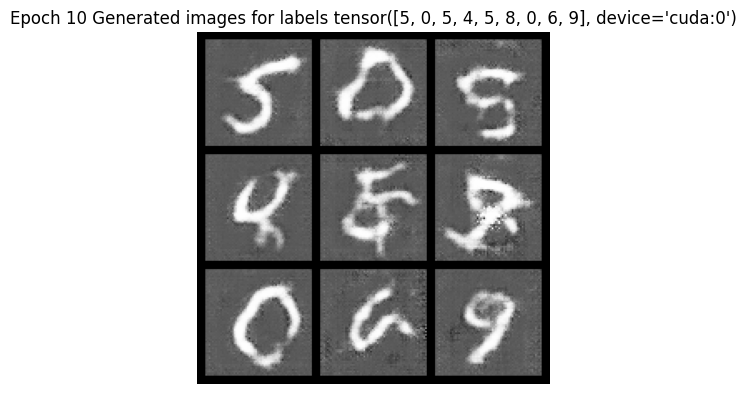

100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 22%|██▏       | 11/50 [06:07<21:43, 33.41s/it]

Discriminator loss for epoch 11 : 0.6326

Discriminator real loss for epoch 11 : 0.6381

Discriminator fake loss for epoch 11 : 0.6270

Generator loss for epoch 11 : 2.0119


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 24%|██▍       | 12/50 [06:40<21:08, 33.39s/it]

Discriminator loss for epoch 12 : 0.6363

Discriminator real loss for epoch 12 : 0.6379

Discriminator fake loss for epoch 12 : 0.6346

Generator loss for epoch 12 : 1.9431


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 26%|██▌       | 13/50 [07:13<20:34, 33.38s/it]

Discriminator loss for epoch 13 : 0.6234

Discriminator real loss for epoch 13 : 0.6279

Discriminator fake loss for epoch 13 : 0.6190

Generator loss for epoch 13 : 1.9812


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 28%|██▊       | 14/50 [07:47<20:01, 33.36s/it]

Discriminator loss for epoch 14 : 0.6196

Discriminator real loss for epoch 14 : 0.6244

Discriminator fake loss for epoch 14 : 0.6148

Generator loss for epoch 14 : 1.9591


100%|██████████| 164/164 [00:33<00:00,  4.90it/s]

 30%|███       | 15/50 [08:20<19:28, 33.39s/it]

Discriminator loss for epoch 15 : 0.6312

Discriminator real loss for epoch 15 : 0.6351

Discriminator fake loss for epoch 15 : 0.6274

Generator loss for epoch 15 : 1.9644


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 32%|███▏      | 16/50 [08:54<18:55, 33.40s/it]

Discriminator loss for epoch 16 : 0.6376

Discriminator real loss for epoch 16 : 0.6419

Discriminator fake loss for epoch 16 : 0.6333

Generator loss for epoch 16 : 1.8690


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 34%|███▍      | 17/50 [09:27<18:22, 33.40s/it]

Discriminator loss for epoch 17 : 0.6281

Discriminator real loss for epoch 17 : 0.6298

Discriminator fake loss for epoch 17 : 0.6263

Generator loss for epoch 17 : 1.9214


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 36%|███▌      | 18/50 [10:00<17:48, 33.38s/it]

Discriminator loss for epoch 18 : 0.6287

Discriminator real loss for epoch 18 : 0.6314

Discriminator fake loss for epoch 18 : 0.6260

Generator loss for epoch 18 : 1.9170


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 38%|███▊      | 19/50 [10:34<17:14, 33.36s/it]

Discriminator loss for epoch 19 : 0.6342

Discriminator real loss for epoch 19 : 0.6360

Discriminator fake loss for epoch 19 : 0.6324

Generator loss for epoch 19 : 1.8909


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]


Discriminator loss for epoch 20 : 0.6424

Discriminator real loss for epoch 20 : 0.6458

Discriminator fake loss for epoch 20 : 0.6390

Generator loss for epoch 20 : 1.8635


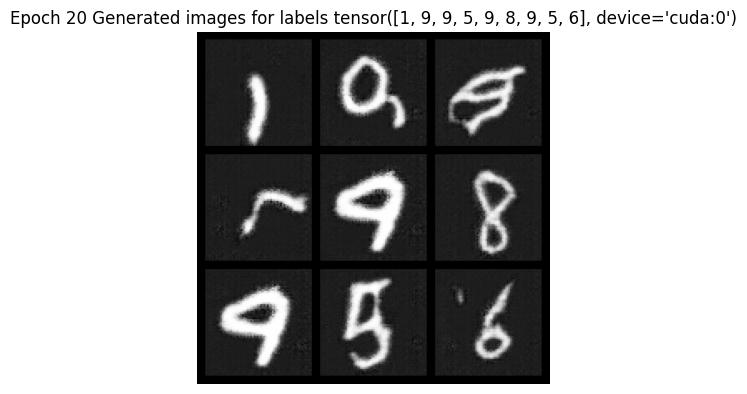

100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 42%|████▏     | 21/50 [11:41<16:09, 33.43s/it]

Discriminator loss for epoch 21 : 0.6425

Discriminator real loss for epoch 21 : 0.6455

Discriminator fake loss for epoch 21 : 0.6394

Generator loss for epoch 21 : 1.8521


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 44%|████▍     | 22/50 [12:14<15:34, 33.39s/it]

Discriminator loss for epoch 22 : 0.6425

Discriminator real loss for epoch 22 : 0.6461

Discriminator fake loss for epoch 22 : 0.6390

Generator loss for epoch 22 : 1.8694


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 46%|████▌     | 23/50 [12:47<15:00, 33.37s/it]

Discriminator loss for epoch 23 : 0.6421

Discriminator real loss for epoch 23 : 0.6427

Discriminator fake loss for epoch 23 : 0.6416

Generator loss for epoch 23 : 1.8587


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 48%|████▊     | 24/50 [13:21<14:27, 33.35s/it]

Discriminator loss for epoch 24 : 0.6420

Discriminator real loss for epoch 24 : 0.6434

Discriminator fake loss for epoch 24 : 0.6406

Generator loss for epoch 24 : 1.8516


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 50%|█████     | 25/50 [13:54<13:54, 33.37s/it]

Discriminator loss for epoch 25 : 0.6393

Discriminator real loss for epoch 25 : 0.6422

Discriminator fake loss for epoch 25 : 0.6363

Generator loss for epoch 25 : 1.8917


100%|██████████| 164/164 [00:33<00:00,  4.86it/s]

 52%|█████▏    | 26/50 [14:28<13:23, 33.47s/it]

Discriminator loss for epoch 26 : 0.6237

Discriminator real loss for epoch 26 : 0.6265

Discriminator fake loss for epoch 26 : 0.6209

Generator loss for epoch 26 : 1.9347


100%|██████████| 164/164 [00:33<00:00,  4.88it/s]

 54%|█████▍    | 27/50 [15:01<12:50, 33.51s/it]

Discriminator loss for epoch 27 : 0.6024

Discriminator real loss for epoch 27 : 0.6079

Discriminator fake loss for epoch 27 : 0.5970

Generator loss for epoch 27 : 2.0714


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 56%|█████▌    | 28/50 [15:35<12:16, 33.48s/it]

Discriminator loss for epoch 28 : 0.6109

Discriminator real loss for epoch 28 : 0.6122

Discriminator fake loss for epoch 28 : 0.6095

Generator loss for epoch 28 : 2.0360


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 58%|█████▊    | 29/50 [16:08<11:42, 33.43s/it]

Discriminator loss for epoch 29 : 0.5966

Discriminator real loss for epoch 29 : 0.5958

Discriminator fake loss for epoch 29 : 0.5973

Generator loss for epoch 29 : 2.0918


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]


Discriminator loss for epoch 30 : 0.5426

Discriminator real loss for epoch 30 : 0.5505

Discriminator fake loss for epoch 30 : 0.5347

Generator loss for epoch 30 : 2.3131


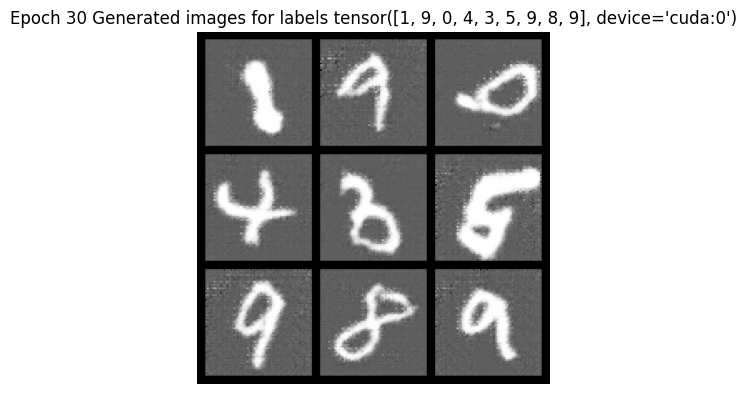

100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 62%|██████▏   | 31/50 [17:15<10:36, 33.49s/it]

Discriminator loss for epoch 31 : 0.5200

Discriminator real loss for epoch 31 : 0.5224

Discriminator fake loss for epoch 31 : 0.5176

Generator loss for epoch 31 : 2.3908


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 64%|██████▍   | 32/50 [17:49<10:01, 33.44s/it]

Discriminator loss for epoch 32 : 0.5306

Discriminator real loss for epoch 32 : 0.5333

Discriminator fake loss for epoch 32 : 0.5279

Generator loss for epoch 32 : 2.3535


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 66%|██████▌   | 33/50 [18:22<09:27, 33.41s/it]

Discriminator loss for epoch 33 : 0.4022

Discriminator real loss for epoch 33 : 0.4067

Discriminator fake loss for epoch 33 : 0.3977

Generator loss for epoch 33 : 2.8118


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 68%|██████▊   | 34/50 [18:55<08:54, 33.39s/it]

Discriminator loss for epoch 34 : 0.0525

Discriminator real loss for epoch 34 : 0.0513

Discriminator fake loss for epoch 34 : 0.0537

Generator loss for epoch 34 : 4.7005


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 70%|███████   | 35/50 [19:29<08:20, 33.37s/it]

Discriminator loss for epoch 35 : 0.1806

Discriminator real loss for epoch 35 : 0.1982

Discriminator fake loss for epoch 35 : 0.1630

Generator loss for epoch 35 : 5.3833


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 72%|███████▏  | 36/50 [20:02<07:46, 33.36s/it]

Discriminator loss for epoch 36 : 0.3655

Discriminator real loss for epoch 36 : 0.3878

Discriminator fake loss for epoch 36 : 0.3433

Generator loss for epoch 36 : 3.9430


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 74%|███████▍  | 37/50 [20:35<07:13, 33.34s/it]

Discriminator loss for epoch 37 : 0.3383

Discriminator real loss for epoch 37 : 0.3503

Discriminator fake loss for epoch 37 : 0.3263

Generator loss for epoch 37 : 3.7708


100%|██████████| 164/164 [00:33<00:00,  4.93it/s]

 76%|███████▌  | 38/50 [21:08<06:39, 33.33s/it]

Discriminator loss for epoch 38 : 0.5992

Discriminator real loss for epoch 38 : 0.6014

Discriminator fake loss for epoch 38 : 0.5969

Generator loss for epoch 38 : 2.0763


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 78%|███████▊  | 39/50 [21:42<06:06, 33.35s/it]

Discriminator loss for epoch 39 : 0.6202

Discriminator real loss for epoch 39 : 0.6221

Discriminator fake loss for epoch 39 : 0.6182

Generator loss for epoch 39 : 2.0517


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]


Discriminator loss for epoch 40 : 0.5599

Discriminator real loss for epoch 40 : 0.5553

Discriminator fake loss for epoch 40 : 0.5645

Generator loss for epoch 40 : 2.2344


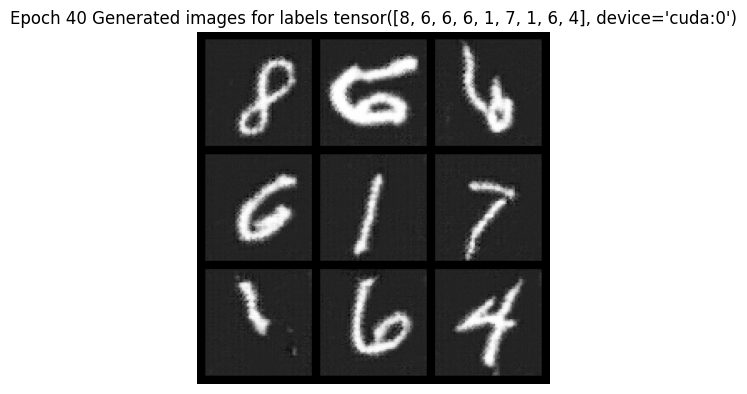

100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 82%|████████▏ | 41/50 [22:49<05:00, 33.43s/it]

Discriminator loss for epoch 41 : 0.5700

Discriminator real loss for epoch 41 : 0.5750

Discriminator fake loss for epoch 41 : 0.5649

Generator loss for epoch 41 : 2.3144


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 84%|████████▍ | 42/50 [23:22<04:27, 33.43s/it]

Discriminator loss for epoch 42 : 0.5170

Discriminator real loss for epoch 42 : 0.5171

Discriminator fake loss for epoch 42 : 0.5169

Generator loss for epoch 42 : 2.4292


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 86%|████████▌ | 43/50 [23:56<03:54, 33.43s/it]

Discriminator loss for epoch 43 : 0.4970

Discriminator real loss for epoch 43 : 0.4908

Discriminator fake loss for epoch 43 : 0.5032

Generator loss for epoch 43 : 2.5848


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 88%|████████▊ | 44/50 [24:29<03:20, 33.40s/it]

Discriminator loss for epoch 44 : 0.4916

Discriminator real loss for epoch 44 : 0.4945

Discriminator fake loss for epoch 44 : 0.4887

Generator loss for epoch 44 : 2.5589


100%|██████████| 164/164 [00:33<00:00,  4.90it/s]

 90%|█████████ | 45/50 [25:03<02:47, 33.42s/it]

Discriminator loss for epoch 45 : 0.5074

Discriminator real loss for epoch 45 : 0.5012

Discriminator fake loss for epoch 45 : 0.5136

Generator loss for epoch 45 : 2.5872


100%|██████████| 164/164 [00:33<00:00,  4.93it/s]

 92%|█████████▏| 46/50 [25:36<02:13, 33.38s/it]

Discriminator loss for epoch 46 : 0.5162

Discriminator real loss for epoch 46 : 0.5084

Discriminator fake loss for epoch 46 : 0.5240

Generator loss for epoch 46 : 2.5109


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 94%|█████████▍| 47/50 [26:09<01:40, 33.37s/it]

Discriminator loss for epoch 47 : 0.4559

Discriminator real loss for epoch 47 : 0.4557

Discriminator fake loss for epoch 47 : 0.4561

Generator loss for epoch 47 : 2.7476


100%|██████████| 164/164 [00:33<00:00,  4.91it/s]

 96%|█████████▌| 48/50 [26:43<01:06, 33.38s/it]

Discriminator loss for epoch 48 : 0.4092

Discriminator real loss for epoch 48 : 0.4129

Discriminator fake loss for epoch 48 : 0.4054

Generator loss for epoch 48 : 3.1919


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]

 98%|█████████▊| 49/50 [27:16<00:33, 33.36s/it]

Discriminator loss for epoch 49 : 0.4679

Discriminator real loss for epoch 49 : 0.4652

Discriminator fake loss for epoch 49 : 0.4706

Generator loss for epoch 49 : 2.8465


100%|██████████| 164/164 [00:33<00:00,  4.92it/s]


Discriminator loss for epoch 50 : 0.4661

Discriminator real loss for epoch 50 : 0.4617

Discriminator fake loss for epoch 50 : 0.4704

Generator loss for epoch 50 : 2.8093


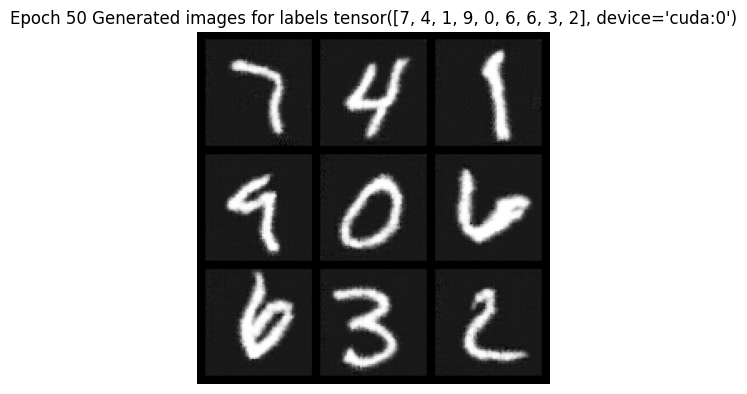

100%|██████████| 50/50 [27:50<00:00, 33.41s/it]

Training time: 1670.26s


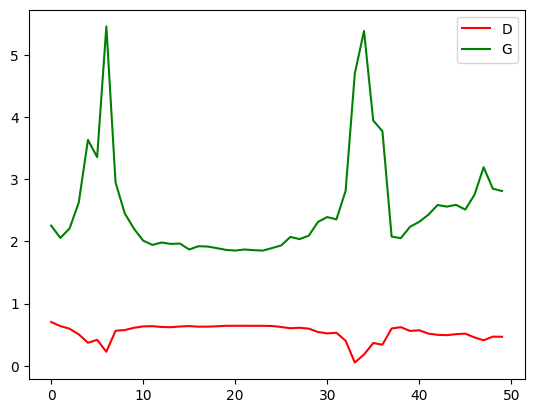

In [15]:
def train_on_dataset(dataset_name, dataset):
    discriminator = Discriminator(params[dataset_name]['feature_map_dim'], 
                                  params[dataset_name]['num_channels'], 
                                  params[dataset_name]['num_classes'], 
                                  params[dataset_name]['embedding_dim']).to(device)
    
    generator = Generator(params[dataset_name]['input_vector_dim'], 
                          params[dataset_name]['feature_map_dim'], 
                          params[dataset_name]['num_channels'], 
                          params[dataset_name]['num_classes'], 
                          params[dataset_name]['embedding_dim']).to(device)

    criterion = nn.BCELoss()
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

    dataloader = DataLoader(dataset, params[dataset_name]['batch_size'], num_workers=num_workers, shuffle=True, drop_last=True)

    generator_loss_per_epoch = []
    discriminator_loss_per_epoch = []
    start = timeit.default_timer()
    num_epochs = params[dataset_name]['num_epochs']
    for epoch in tqdm(range(num_epochs), position=0, leave=True):
        generator.train()
        discriminator.train() # postavljanje moda za treniranjeRuntimeError: GET was unable to find an engine to execute this computation
        
        generator_running_loss = 0
        discriminator_running_loss = 0
        discriminator_fake_running_loss = 0
        discriminator_real_running_loss = 0
        for idx, data in enumerate(tqdm(dataloader, position=0, leave=True)): 
            img_data = data[0].to(device) 
            label = data[1].to(device)
            bs = data[0].shape[0]
            
            real_labels = torch.ones(bs, dtype=torch.float).to(device) 
            fake_labels = torch.zeros(bs, dtype=torch.float).to(device) 
            noise = torch.randn(bs, params[dataset_name]['input_vector_dim'], 1, 1).to(device) 
            
            
            discriminator_real_out = discriminator(img_data, label).view(-1) 
            discriminator_real_loss = criterion(discriminator_real_out, real_labels)
            discriminator_optimizer.zero_grad()
            
            generator_fake_out = generator(noise, label) 
            discriminator_fake_out = discriminator(generator_fake_out.detach(), label).view(-1)
            discriminator_fake_loss = criterion(discriminator_fake_out, fake_labels)
            discriminator_loss = discriminator_real_loss + discriminator_fake_loss
            
            discriminator_loss.backward()
            discriminator_optimizer.step() 
            
            discriminator_running_loss += discriminator_loss.item()
            discriminator_fake_running_loss += discriminator_fake_loss.item()
            discriminator_real_running_loss += discriminator_real_loss.item()
            
            
            
            discriminator_fake_out = discriminator(generator_fake_out, label).view(-1)
            generator_loss = criterion(discriminator_fake_out, real_labels) \
                + torch.abs(img_data - generator_fake_out).mean() * params[dataset_name]['reconstruction_weight']
            generator_running_loss += generator_loss.item()
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
            
        discriminator_loss = discriminator_running_loss / (2 * (idx + 1))
        discriminator_fake_loss = discriminator_fake_running_loss / (idx + 1)
        discriminator_real_loss = discriminator_real_running_loss / (idx + 1)
        generator_loss = generator_running_loss / (idx + 1)
            
        print(f'Discriminator loss for epoch {epoch+1} : {discriminator_loss:.4f}')
        print(f'Discriminator real loss for epoch {epoch+1} : {discriminator_real_loss:.4f}')
        print(f'Discriminator fake loss for epoch {epoch+1} : {discriminator_fake_loss:.4f}')
        print(f'Generator loss for epoch {epoch + 1} : {generator_loss:.4f}')
            
        discriminator_loss_per_epoch.append(discriminator_loss)
        generator_loss_per_epoch.append(generator_loss)
        
        if (epoch + 1) % checkpoint_frequency == 0:
            generator_path = f'{dataset_name}_generator_{epoch:06d}.ckpt'
            discriminator_path = f'{dataset_name}_discriminator_{epoch:06d}.ckpt'
        
            torch.save(generator.state_dict(), generator_path)
            torch.save(discriminator.state_dict(), discriminator_path)
            
            plt.figure(figsize=(10,10))
            plt.subplot(1,2,1)
            plt.axis("off")
            indices = torch.randint(0, len(label), (9,))
            plt.title(f'Epoch {epoch + 1} Generated images for labels {label[indices]}')
            plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[indices], padding=5, normalize=True, nrow=3).cpu(), (1,2,0)))
            plt.show()
            
    stop = timeit.default_timer()
    print(f'Training time: {stop-start:.2f}s')
    plt.plot(range(num_epochs), discriminator_loss_per_epoch, 'r', label='D')
    plt.plot(range(num_epochs), generator_loss_per_epoch, 'g', label='G')
    plt.legend()
    plt.show()
    
    discriminator.cpu()
    generator.cpu()
    del discriminator
    del generator
    gc.collect()

train_on_dataset('MNIST', datasetMNIST)

100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

  1%|          | 1/100 [00:27<45:31, 27.59s/it]

Discriminator loss for epoch 1 : 0.5921

Discriminator real loss for epoch 1 : 0.6262

Discriminator fake loss for epoch 1 : 0.5581

Generator loss for epoch 1 : 6.9795


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

  2%|▏         | 2/100 [00:55<45:09, 27.65s/it]

Discriminator loss for epoch 2 : 0.6089

Discriminator real loss for epoch 2 : 0.6292

Discriminator fake loss for epoch 2 : 0.5886

Generator loss for epoch 2 : 4.2423


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

  3%|▎         | 3/100 [01:22<44:38, 27.62s/it]

Discriminator loss for epoch 3 : 0.6620

Discriminator real loss for epoch 3 : 0.6660

Discriminator fake loss for epoch 3 : 0.6580

Generator loss for epoch 3 : 3.8921


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

  4%|▍         | 4/100 [01:50<44:08, 27.59s/it]

Discriminator loss for epoch 4 : 0.6481

Discriminator real loss for epoch 4 : 0.6470

Discriminator fake loss for epoch 4 : 0.6491

Generator loss for epoch 4 : 3.9634


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

  5%|▌         | 5/100 [02:18<43:44, 27.63s/it]

Discriminator loss for epoch 5 : 0.6434

Discriminator real loss for epoch 5 : 0.6497

Discriminator fake loss for epoch 5 : 0.6371

Generator loss for epoch 5 : 4.1980


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

  6%|▌         | 6/100 [02:45<43:15, 27.62s/it]

Discriminator loss for epoch 6 : 0.6501

Discriminator real loss for epoch 6 : 0.6568

Discriminator fake loss for epoch 6 : 0.6435

Generator loss for epoch 6 : 4.1775


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

  7%|▋         | 7/100 [03:13<42:47, 27.61s/it]

Discriminator loss for epoch 7 : 0.6433

Discriminator real loss for epoch 7 : 0.6501

Discriminator fake loss for epoch 7 : 0.6365

Generator loss for epoch 7 : 4.1900


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

  8%|▊         | 8/100 [03:40<42:20, 27.61s/it]

Discriminator loss for epoch 8 : 0.6288

Discriminator real loss for epoch 8 : 0.6381

Discriminator fake loss for epoch 8 : 0.6195

Generator loss for epoch 8 : 4.3302


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

  9%|▉         | 9/100 [04:08<41:51, 27.60s/it]

Discriminator loss for epoch 9 : 0.6231

Discriminator real loss for epoch 9 : 0.6325

Discriminator fake loss for epoch 9 : 0.6137

Generator loss for epoch 9 : 4.4312


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]


Discriminator loss for epoch 10 : 0.6264

Discriminator real loss for epoch 10 : 0.6380

Discriminator fake loss for epoch 10 : 0.6148

Generator loss for epoch 10 : 4.4561


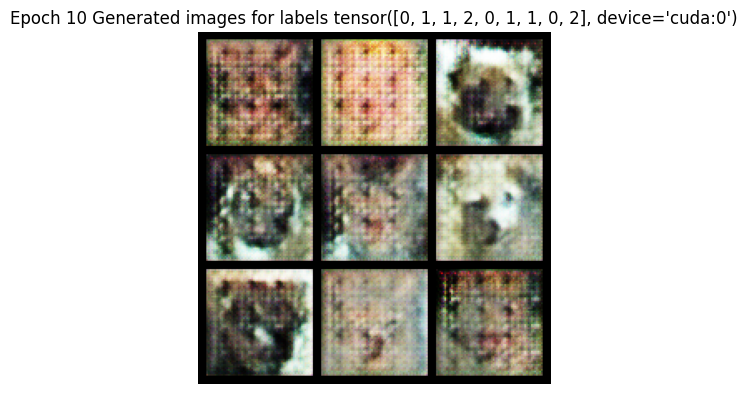

100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 11%|█         | 11/100 [05:04<41:13, 27.79s/it]

Discriminator loss for epoch 11 : 0.6123

Discriminator real loss for epoch 11 : 0.6232

Discriminator fake loss for epoch 11 : 0.6014

Generator loss for epoch 11 : 4.6505


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 12%|█▏        | 12/100 [05:32<40:39, 27.72s/it]

Discriminator loss for epoch 12 : 0.5841

Discriminator real loss for epoch 12 : 0.6075

Discriminator fake loss for epoch 12 : 0.5606

Generator loss for epoch 12 : 4.9253


100%|██████████| 126/126 [00:27<00:00,  4.54it/s]

 13%|█▎        | 13/100 [05:59<40:12, 27.73s/it]

Discriminator loss for epoch 13 : 0.5035

Discriminator real loss for epoch 13 : 0.5481

Discriminator fake loss for epoch 13 : 0.4590

Generator loss for epoch 13 : 5.6521


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 14%|█▍        | 14/100 [06:27<39:41, 27.69s/it]

Discriminator loss for epoch 14 : 0.5213

Discriminator real loss for epoch 14 : 0.5244

Discriminator fake loss for epoch 14 : 0.5182

Generator loss for epoch 14 : 5.0884


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 15%|█▌        | 15/100 [06:55<39:11, 27.66s/it]

Discriminator loss for epoch 15 : 0.5815

Discriminator real loss for epoch 15 : 0.6170

Discriminator fake loss for epoch 15 : 0.5460

Generator loss for epoch 15 : 5.0149


100%|██████████| 126/126 [00:27<00:00,  4.58it/s]

 16%|█▌        | 16/100 [07:22<38:40, 27.62s/it]

Discriminator loss for epoch 16 : 0.4979

Discriminator real loss for epoch 16 : 0.5205

Discriminator fake loss for epoch 16 : 0.4753

Generator loss for epoch 16 : 5.6277


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 17%|█▋        | 17/100 [07:50<38:13, 27.63s/it]

Discriminator loss for epoch 17 : 0.4534

Discriminator real loss for epoch 17 : 0.5158

Discriminator fake loss for epoch 17 : 0.3909

Generator loss for epoch 17 : 6.4187


100%|██████████| 126/126 [00:27<00:00,  4.51it/s]

 18%|█▊        | 18/100 [08:18<37:52, 27.71s/it]

Discriminator loss for epoch 18 : 0.5353

Discriminator real loss for epoch 18 : 0.5451

Discriminator fake loss for epoch 18 : 0.5255

Generator loss for epoch 18 : 4.9829


100%|██████████| 126/126 [00:27<00:00,  4.53it/s]

 19%|█▉        | 19/100 [08:45<37:27, 27.75s/it]

Discriminator loss for epoch 19 : 0.5336

Discriminator real loss for epoch 19 : 0.5461

Discriminator fake loss for epoch 19 : 0.5212

Generator loss for epoch 19 : 5.3158


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Discriminator loss for epoch 20 : 0.5301

Discriminator real loss for epoch 20 : 0.5413

Discriminator fake loss for epoch 20 : 0.5190

Generator loss for epoch 20 : 5.3079


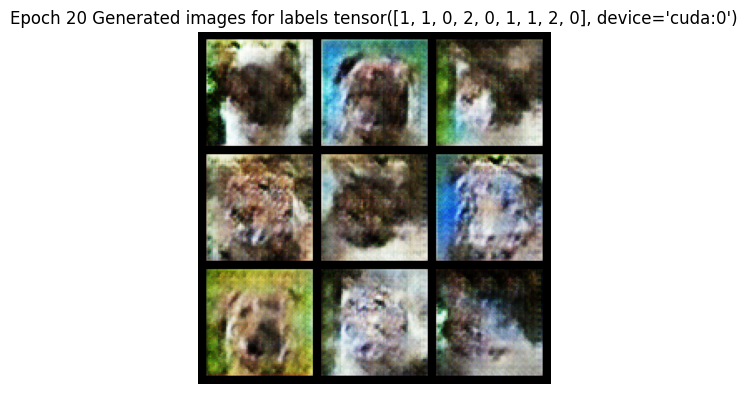

100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 21%|██        | 21/100 [09:41<36:39, 27.84s/it]

Discriminator loss for epoch 21 : 0.5473

Discriminator real loss for epoch 21 : 0.5779

Discriminator fake loss for epoch 21 : 0.5167

Generator loss for epoch 21 : 5.2885


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 22%|██▏       | 22/100 [10:09<36:06, 27.78s/it]

Discriminator loss for epoch 22 : 0.4927

Discriminator real loss for epoch 22 : 0.5202

Discriminator fake loss for epoch 22 : 0.4653

Generator loss for epoch 22 : 5.7128


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 23%|██▎       | 23/100 [10:37<35:37, 27.76s/it]

Discriminator loss for epoch 23 : 0.4817

Discriminator real loss for epoch 23 : 0.5163

Discriminator fake loss for epoch 23 : 0.4471

Generator loss for epoch 23 : 6.0203


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 24%|██▍       | 24/100 [11:05<35:08, 27.75s/it]

Discriminator loss for epoch 24 : 0.4751

Discriminator real loss for epoch 24 : 0.4970

Discriminator fake loss for epoch 24 : 0.4532

Generator loss for epoch 24 : 5.7415


100%|██████████| 126/126 [00:27<00:00,  4.54it/s]

 25%|██▌       | 25/100 [11:32<34:41, 27.75s/it]

Discriminator loss for epoch 25 : 0.3343

Discriminator real loss for epoch 25 : 0.3728

Discriminator fake loss for epoch 25 : 0.2958

Generator loss for epoch 25 : 6.8124


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 26%|██▌       | 26/100 [12:00<34:11, 27.73s/it]

Discriminator loss for epoch 26 : 0.3906

Discriminator real loss for epoch 26 : 0.4031

Discriminator fake loss for epoch 26 : 0.3782

Generator loss for epoch 26 : 6.2421


100%|██████████| 126/126 [00:27<00:00,  4.53it/s]

 27%|██▋       | 27/100 [12:28<33:46, 27.76s/it]

Discriminator loss for epoch 27 : 0.3840

Discriminator real loss for epoch 27 : 0.4101

Discriminator fake loss for epoch 27 : 0.3578

Generator loss for epoch 27 : 6.2206


100%|██████████| 126/126 [00:27<00:00,  4.58it/s]

 28%|██▊       | 28/100 [12:55<33:13, 27.69s/it]

Discriminator loss for epoch 28 : 0.3789

Discriminator real loss for epoch 28 : 0.3884

Discriminator fake loss for epoch 28 : 0.3695

Generator loss for epoch 28 : 6.1310


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 29%|██▉       | 29/100 [13:23<32:44, 27.67s/it]

Discriminator loss for epoch 29 : 0.3671

Discriminator real loss for epoch 29 : 0.3692

Discriminator fake loss for epoch 29 : 0.3650

Generator loss for epoch 29 : 6.0996


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Discriminator loss for epoch 30 : 0.3703

Discriminator real loss for epoch 30 : 0.3899

Discriminator fake loss for epoch 30 : 0.3508

Generator loss for epoch 30 : 6.2879


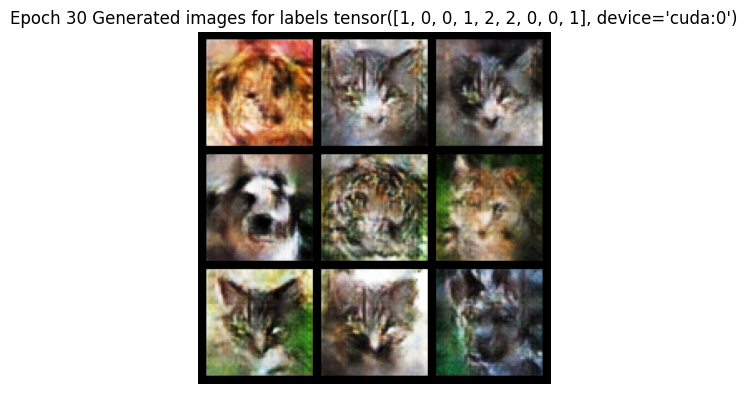

100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 31%|███       | 31/100 [14:19<31:54, 27.74s/it]

Discriminator loss for epoch 31 : 0.3241

Discriminator real loss for epoch 31 : 0.3468

Discriminator fake loss for epoch 31 : 0.3015

Generator loss for epoch 31 : 6.3066


100%|██████████| 126/126 [00:27<00:00,  4.54it/s]

 32%|███▏      | 32/100 [14:46<31:26, 27.74s/it]

Discriminator loss for epoch 32 : 0.3658

Discriminator real loss for epoch 32 : 0.3700

Discriminator fake loss for epoch 32 : 0.3615

Generator loss for epoch 32 : 6.2587


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 33%|███▎      | 33/100 [15:14<30:57, 27.72s/it]

Discriminator loss for epoch 33 : 0.3290

Discriminator real loss for epoch 33 : 0.3722

Discriminator fake loss for epoch 33 : 0.2859

Generator loss for epoch 33 : 6.7383


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 34%|███▍      | 34/100 [15:42<30:27, 27.69s/it]

Discriminator loss for epoch 34 : 0.3426

Discriminator real loss for epoch 34 : 0.3476

Discriminator fake loss for epoch 34 : 0.3376

Generator loss for epoch 34 : 6.3344


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 35%|███▌      | 35/100 [16:09<29:59, 27.69s/it]

Discriminator loss for epoch 35 : 0.3194

Discriminator real loss for epoch 35 : 0.3255

Discriminator fake loss for epoch 35 : 0.3132

Generator loss for epoch 35 : 6.5448


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 36%|███▌      | 36/100 [16:37<29:29, 27.65s/it]

Discriminator loss for epoch 36 : 0.2899

Discriminator real loss for epoch 36 : 0.2946

Discriminator fake loss for epoch 36 : 0.2853

Generator loss for epoch 36 : 6.6072


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 37%|███▋      | 37/100 [17:05<29:01, 27.64s/it]

Discriminator loss for epoch 37 : 0.3786

Discriminator real loss for epoch 37 : 0.3850

Discriminator fake loss for epoch 37 : 0.3721

Generator loss for epoch 37 : 6.4991


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 38%|███▊      | 38/100 [17:32<28:32, 27.63s/it]

Discriminator loss for epoch 38 : 0.3061

Discriminator real loss for epoch 38 : 0.3183

Discriminator fake loss for epoch 38 : 0.2938

Generator loss for epoch 38 : 6.6056


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 39%|███▉      | 39/100 [18:00<28:05, 27.63s/it]

Discriminator loss for epoch 39 : 0.3038

Discriminator real loss for epoch 39 : 0.2954

Discriminator fake loss for epoch 39 : 0.3122

Generator loss for epoch 39 : 6.6958


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Discriminator loss for epoch 40 : 0.2658

Discriminator real loss for epoch 40 : 0.2674

Discriminator fake loss for epoch 40 : 0.2642

Generator loss for epoch 40 : 6.8362


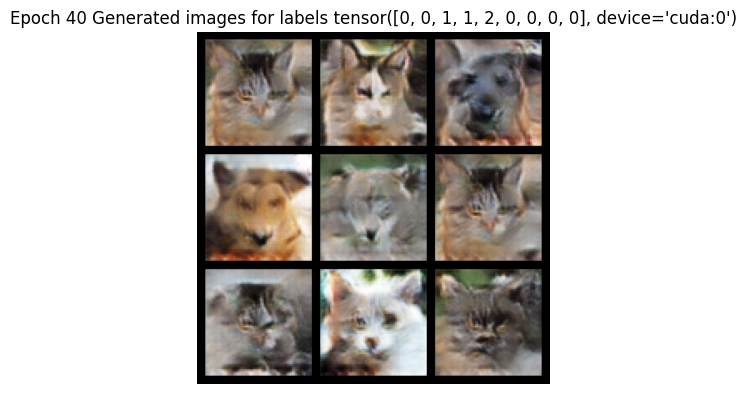

100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 41%|████      | 41/100 [18:56<27:17, 27.75s/it]

Discriminator loss for epoch 41 : 0.2495

Discriminator real loss for epoch 41 : 0.2549

Discriminator fake loss for epoch 41 : 0.2440

Generator loss for epoch 41 : 7.0600


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 42%|████▏     | 42/100 [19:23<26:46, 27.70s/it]

Discriminator loss for epoch 42 : 0.2862

Discriminator real loss for epoch 42 : 0.3050

Discriminator fake loss for epoch 42 : 0.2673

Generator loss for epoch 42 : 7.0733


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 43%|████▎     | 43/100 [19:51<26:18, 27.69s/it]

Discriminator loss for epoch 43 : 0.2685

Discriminator real loss for epoch 43 : 0.2731

Discriminator fake loss for epoch 43 : 0.2640

Generator loss for epoch 43 : 7.1353


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 44%|████▍     | 44/100 [20:19<25:49, 27.68s/it]

Discriminator loss for epoch 44 : 0.2373

Discriminator real loss for epoch 44 : 0.2516

Discriminator fake loss for epoch 44 : 0.2229

Generator loss for epoch 44 : 7.2366


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 45%|████▌     | 45/100 [20:46<25:21, 27.66s/it]

Discriminator loss for epoch 45 : 0.2688

Discriminator real loss for epoch 45 : 0.2791

Discriminator fake loss for epoch 45 : 0.2585

Generator loss for epoch 45 : 7.0473


100%|██████████| 126/126 [00:27<00:00,  4.51it/s]

 46%|████▌     | 46/100 [21:14<24:57, 27.74s/it]

Discriminator loss for epoch 46 : 0.2670

Discriminator real loss for epoch 46 : 0.2668

Discriminator fake loss for epoch 46 : 0.2671

Generator loss for epoch 46 : 7.3259


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 47%|████▋     | 47/100 [21:42<24:28, 27.70s/it]

Discriminator loss for epoch 47 : 0.2535

Discriminator real loss for epoch 47 : 0.2628

Discriminator fake loss for epoch 47 : 0.2442

Generator loss for epoch 47 : 7.3712


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 48%|████▊     | 48/100 [22:09<23:59, 27.69s/it]

Discriminator loss for epoch 48 : 0.2372

Discriminator real loss for epoch 48 : 0.2377

Discriminator fake loss for epoch 48 : 0.2368

Generator loss for epoch 48 : 7.4174


100%|██████████| 126/126 [00:28<00:00,  4.50it/s]

 49%|████▉     | 49/100 [22:37<23:37, 27.79s/it]

Discriminator loss for epoch 49 : 0.2287

Discriminator real loss for epoch 49 : 0.2368

Discriminator fake loss for epoch 49 : 0.2206

Generator loss for epoch 49 : 7.4737


100%|██████████| 126/126 [00:28<00:00,  4.50it/s]


Discriminator loss for epoch 50 : 0.2735

Discriminator real loss for epoch 50 : 0.2929

Discriminator fake loss for epoch 50 : 0.2540

Generator loss for epoch 50 : 7.5027


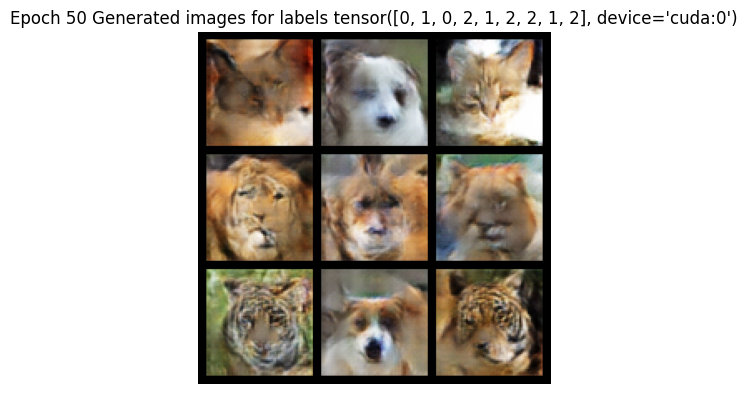

100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 51%|█████     | 51/100 [23:34<22:51, 27.99s/it]

Discriminator loss for epoch 51 : 0.1967

Discriminator real loss for epoch 51 : 0.1987

Discriminator fake loss for epoch 51 : 0.1947

Generator loss for epoch 51 : 7.4636


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 52%|█████▏    | 52/100 [24:02<22:17, 27.86s/it]

Discriminator loss for epoch 52 : 0.1832

Discriminator real loss for epoch 52 : 0.1870

Discriminator fake loss for epoch 52 : 0.1793

Generator loss for epoch 52 : 7.5515


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 53%|█████▎    | 53/100 [24:29<21:45, 27.79s/it]

Discriminator loss for epoch 53 : 0.2021

Discriminator real loss for epoch 53 : 0.2072

Discriminator fake loss for epoch 53 : 0.1969

Generator loss for epoch 53 : 7.7313


100%|██████████| 126/126 [00:27<00:00,  4.58it/s]

 54%|█████▍    | 54/100 [24:57<21:14, 27.71s/it]

Discriminator loss for epoch 54 : 0.1367

Discriminator real loss for epoch 54 : 0.1409

Discriminator fake loss for epoch 54 : 0.1325

Generator loss for epoch 54 : 7.7973


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 55%|█████▌    | 55/100 [25:24<20:47, 27.71s/it]

Discriminator loss for epoch 55 : 0.2735

Discriminator real loss for epoch 55 : 0.2845

Discriminator fake loss for epoch 55 : 0.2626

Generator loss for epoch 55 : 7.9654


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 56%|█████▌    | 56/100 [25:52<20:18, 27.68s/it]

Discriminator loss for epoch 56 : 0.2340

Discriminator real loss for epoch 56 : 0.2451

Discriminator fake loss for epoch 56 : 0.2228

Generator loss for epoch 56 : 7.8153


100%|██████████| 126/126 [00:27<00:00,  4.54it/s]

 57%|█████▋    | 57/100 [26:20<19:51, 27.71s/it]

Discriminator loss for epoch 57 : 0.1189

Discriminator real loss for epoch 57 : 0.1230

Discriminator fake loss for epoch 57 : 0.1148

Generator loss for epoch 57 : 7.8732


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 58%|█████▊    | 58/100 [26:47<19:22, 27.67s/it]

Discriminator loss for epoch 58 : 0.3008

Discriminator real loss for epoch 58 : 0.3090

Discriminator fake loss for epoch 58 : 0.2926

Generator loss for epoch 58 : 8.1100


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 59%|█████▉    | 59/100 [27:15<18:53, 27.64s/it]

Discriminator loss for epoch 59 : 0.1732

Discriminator real loss for epoch 59 : 0.1766

Discriminator fake loss for epoch 59 : 0.1698

Generator loss for epoch 59 : 7.5242


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Discriminator loss for epoch 60 : 0.3013

Discriminator real loss for epoch 60 : 0.3015

Discriminator fake loss for epoch 60 : 0.3010

Generator loss for epoch 60 : 8.1414


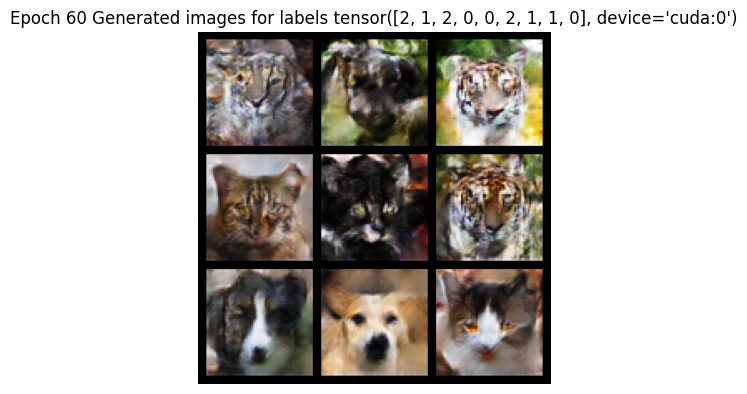

100%|██████████| 126/126 [00:27<00:00,  4.54it/s]

 61%|██████    | 61/100 [28:11<18:06, 27.85s/it]

Discriminator loss for epoch 61 : 0.1731

Discriminator real loss for epoch 61 : 0.1739

Discriminator fake loss for epoch 61 : 0.1723

Generator loss for epoch 61 : 7.4941


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 62%|██████▏   | 62/100 [28:39<17:35, 27.79s/it]

Discriminator loss for epoch 62 : 0.1919

Discriminator real loss for epoch 62 : 0.2001

Discriminator fake loss for epoch 62 : 0.1837

Generator loss for epoch 62 : 7.9076


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 63%|██████▎   | 63/100 [29:06<17:06, 27.75s/it]

Discriminator loss for epoch 63 : 0.1756

Discriminator real loss for epoch 63 : 0.1870

Discriminator fake loss for epoch 63 : 0.1642

Generator loss for epoch 63 : 7.9088


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 64%|██████▍   | 64/100 [29:34<16:38, 27.73s/it]

Discriminator loss for epoch 64 : 0.1552

Discriminator real loss for epoch 64 : 0.1589

Discriminator fake loss for epoch 64 : 0.1515

Generator loss for epoch 64 : 7.8435


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 65%|██████▌   | 65/100 [30:02<16:09, 27.71s/it]

Discriminator loss for epoch 65 : 0.1526

Discriminator real loss for epoch 65 : 0.1569

Discriminator fake loss for epoch 65 : 0.1483

Generator loss for epoch 65 : 7.9990


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 66%|██████▌   | 66/100 [30:29<15:41, 27.68s/it]

Discriminator loss for epoch 66 : 0.1563

Discriminator real loss for epoch 66 : 0.1635

Discriminator fake loss for epoch 66 : 0.1490

Generator loss for epoch 66 : 8.1080


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 67%|██████▋   | 67/100 [30:57<15:12, 27.67s/it]

Discriminator loss for epoch 67 : 0.3407

Discriminator real loss for epoch 67 : 0.3586

Discriminator fake loss for epoch 67 : 0.3227

Generator loss for epoch 67 : 8.2510


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 68%|██████▊   | 68/100 [31:25<14:44, 27.63s/it]

Discriminator loss for epoch 68 : 0.1616

Discriminator real loss for epoch 68 : 0.1673

Discriminator fake loss for epoch 68 : 0.1559

Generator loss for epoch 68 : 7.6081


100%|██████████| 126/126 [00:27<00:00,  4.54it/s]

 69%|██████▉   | 69/100 [31:52<14:17, 27.66s/it]

Discriminator loss for epoch 69 : 0.1517

Discriminator real loss for epoch 69 : 0.1516

Discriminator fake loss for epoch 69 : 0.1518

Generator loss for epoch 69 : 7.8385


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]


Discriminator loss for epoch 70 : 0.1531

Discriminator real loss for epoch 70 : 0.1551

Discriminator fake loss for epoch 70 : 0.1510

Generator loss for epoch 70 : 7.8137


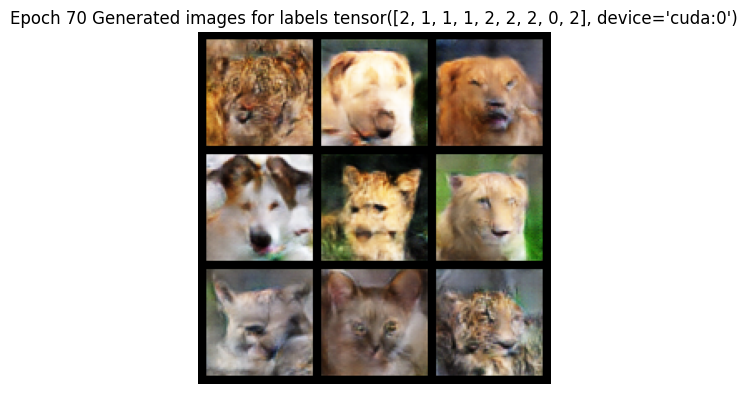

100%|██████████| 126/126 [00:27<00:00,  4.51it/s]

 71%|███████   | 71/100 [32:49<13:28, 27.87s/it]

Discriminator loss for epoch 71 : 0.1857

Discriminator real loss for epoch 71 : 0.1974

Discriminator fake loss for epoch 71 : 0.1739

Generator loss for epoch 71 : 8.1443


100%|██████████| 126/126 [00:27<00:00,  4.54it/s]

 72%|███████▏  | 72/100 [33:16<12:59, 27.83s/it]

Discriminator loss for epoch 72 : 0.1385

Discriminator real loss for epoch 72 : 0.1376

Discriminator fake loss for epoch 72 : 0.1394

Generator loss for epoch 72 : 7.9397


100%|██████████| 126/126 [00:27<00:00,  4.53it/s]

 73%|███████▎  | 73/100 [33:44<12:31, 27.83s/it]

Discriminator loss for epoch 73 : 0.2801

Discriminator real loss for epoch 73 : 0.2851

Discriminator fake loss for epoch 73 : 0.2750

Generator loss for epoch 73 : 8.2397


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 74%|███████▍  | 74/100 [34:12<12:01, 27.75s/it]

Discriminator loss for epoch 74 : 0.1532

Discriminator real loss for epoch 74 : 0.1548

Discriminator fake loss for epoch 74 : 0.1515

Generator loss for epoch 74 : 7.6996


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]

 75%|███████▌  | 75/100 [34:40<11:36, 27.84s/it]

Discriminator loss for epoch 75 : 0.1176

Discriminator real loss for epoch 75 : 0.1190

Discriminator fake loss for epoch 75 : 0.1162

Generator loss for epoch 75 : 7.7532


100%|██████████| 126/126 [00:28<00:00,  4.47it/s]

 76%|███████▌  | 76/100 [35:08<11:10, 27.94s/it]

Discriminator loss for epoch 76 : 0.1815

Discriminator real loss for epoch 76 : 0.1841

Discriminator fake loss for epoch 76 : 0.1789

Generator loss for epoch 76 : 8.2517


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 77%|███████▋  | 77/100 [35:36<10:40, 27.85s/it]

Discriminator loss for epoch 77 : 0.1383

Discriminator real loss for epoch 77 : 0.1397

Discriminator fake loss for epoch 77 : 0.1369

Generator loss for epoch 77 : 8.0522


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 78%|███████▊  | 78/100 [36:03<10:10, 27.77s/it]

Discriminator loss for epoch 78 : 0.2258

Discriminator real loss for epoch 78 : 0.2315

Discriminator fake loss for epoch 78 : 0.2201

Generator loss for epoch 78 : 8.2798


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 79%|███████▉  | 79/100 [36:31<09:42, 27.72s/it]

Discriminator loss for epoch 79 : 0.1470

Discriminator real loss for epoch 79 : 0.1501

Discriminator fake loss for epoch 79 : 0.1440

Generator loss for epoch 79 : 7.9416


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Discriminator loss for epoch 80 : 0.1079

Discriminator real loss for epoch 80 : 0.1077

Discriminator fake loss for epoch 80 : 0.1080

Generator loss for epoch 80 : 7.8131


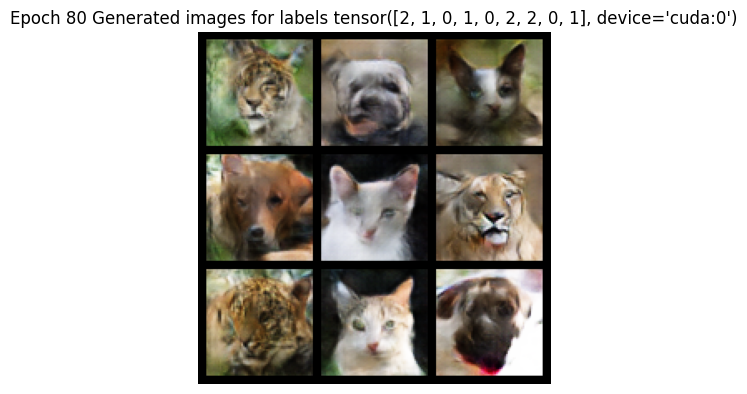

100%|██████████| 126/126 [00:27<00:00,  4.58it/s]

 81%|████████  | 81/100 [37:27<08:48, 27.82s/it]

Discriminator loss for epoch 81 : 0.1480

Discriminator real loss for epoch 81 : 0.1521

Discriminator fake loss for epoch 81 : 0.1439

Generator loss for epoch 81 : 8.3498


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 82%|████████▏ | 82/100 [37:54<08:19, 27.78s/it]

Discriminator loss for epoch 82 : 0.1681

Discriminator real loss for epoch 82 : 0.1727

Discriminator fake loss for epoch 82 : 0.1635

Generator loss for epoch 82 : 8.2957


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 83%|████████▎ | 83/100 [38:22<07:51, 27.72s/it]

Discriminator loss for epoch 83 : 0.0909

Discriminator real loss for epoch 83 : 0.0905

Discriminator fake loss for epoch 83 : 0.0914

Generator loss for epoch 83 : 7.9867


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 84%|████████▍ | 84/100 [38:50<07:23, 27.69s/it]

Discriminator loss for epoch 84 : 0.1825

Discriminator real loss for epoch 84 : 0.1847

Discriminator fake loss for epoch 84 : 0.1803

Generator loss for epoch 84 : 8.9728


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 85%|████████▌ | 85/100 [39:17<06:54, 27.67s/it]

Discriminator loss for epoch 85 : 0.1190

Discriminator real loss for epoch 85 : 0.1205

Discriminator fake loss for epoch 85 : 0.1175

Generator loss for epoch 85 : 8.2524


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 86%|████████▌ | 86/100 [39:45<06:27, 27.67s/it]

Discriminator loss for epoch 86 : 0.9415

Discriminator real loss for epoch 86 : 0.5664

Discriminator fake loss for epoch 86 : 1.3165

Generator loss for epoch 86 : 7.1237


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 87%|████████▋ | 87/100 [40:13<05:59, 27.65s/it]

Discriminator loss for epoch 87 : 0.4194

Discriminator real loss for epoch 87 : 0.4257

Discriminator fake loss for epoch 87 : 0.4130

Generator loss for epoch 87 : 7.3872


100%|██████████| 126/126 [00:27<00:00,  4.58it/s]

 88%|████████▊ | 88/100 [40:40<05:31, 27.62s/it]

Discriminator loss for epoch 88 : 0.1536

Discriminator real loss for epoch 88 : 0.1550

Discriminator fake loss for epoch 88 : 0.1522

Generator loss for epoch 88 : 7.3485


100%|██████████| 126/126 [00:27<00:00,  4.57it/s]

 89%|████████▉ | 89/100 [41:08<05:03, 27.61s/it]

Discriminator loss for epoch 89 : 0.1144

Discriminator real loss for epoch 89 : 0.1153

Discriminator fake loss for epoch 89 : 0.1136

Generator loss for epoch 89 : 7.4649


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Discriminator loss for epoch 90 : 0.2072

Discriminator real loss for epoch 90 : 0.2055

Discriminator fake loss for epoch 90 : 0.2089

Generator loss for epoch 90 : 7.8190


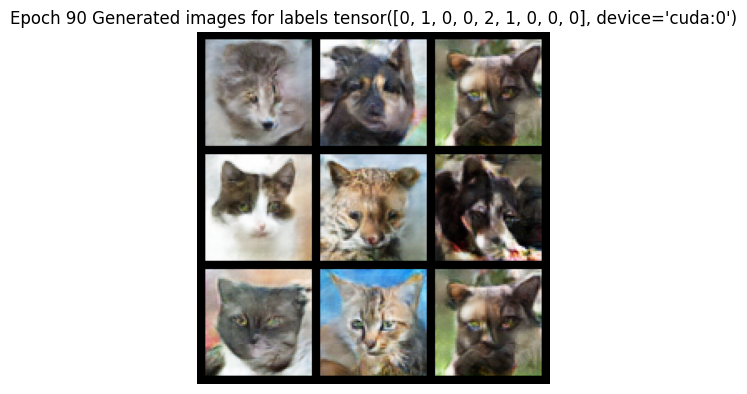

100%|██████████| 126/126 [00:27<00:00,  4.58it/s]

 91%|█████████ | 91/100 [42:04<04:09, 27.77s/it]

Discriminator loss for epoch 91 : 0.0965

Discriminator real loss for epoch 91 : 0.0956

Discriminator fake loss for epoch 91 : 0.0975

Generator loss for epoch 91 : 7.6495


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 92%|█████████▏| 92/100 [42:31<03:41, 27.73s/it]

Discriminator loss for epoch 92 : 0.0662

Discriminator real loss for epoch 92 : 0.0666

Discriminator fake loss for epoch 92 : 0.0658

Generator loss for epoch 92 : 7.8850


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 93%|█████████▎| 93/100 [42:59<03:13, 27.71s/it]

Discriminator loss for epoch 93 : 0.0838

Discriminator real loss for epoch 93 : 0.0869

Discriminator fake loss for epoch 93 : 0.0807

Generator loss for epoch 93 : 8.4364


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 94%|█████████▍| 94/100 [43:27<02:46, 27.69s/it]

Discriminator loss for epoch 94 : 0.3622

Discriminator real loss for epoch 94 : 0.3717

Discriminator fake loss for epoch 94 : 0.3527

Generator loss for epoch 94 : 8.4648


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 95%|█████████▌| 95/100 [43:54<02:18, 27.67s/it]

Discriminator loss for epoch 95 : 0.1635

Discriminator real loss for epoch 95 : 0.1692

Discriminator fake loss for epoch 95 : 0.1578

Generator loss for epoch 95 : 8.1255


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 96%|█████████▌| 96/100 [44:22<01:50, 27.66s/it]

Discriminator loss for epoch 96 : 0.0936

Discriminator real loss for epoch 96 : 0.0948

Discriminator fake loss for epoch 96 : 0.0924

Generator loss for epoch 96 : 7.5981


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]

 97%|█████████▋| 97/100 [44:50<01:23, 27.67s/it]

Discriminator loss for epoch 97 : 0.3344

Discriminator real loss for epoch 97 : 0.3021

Discriminator fake loss for epoch 97 : 0.3667

Generator loss for epoch 97 : 7.7456


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]

 98%|█████████▊| 98/100 [45:17<00:55, 27.66s/it]

Discriminator loss for epoch 98 : 0.2390

Discriminator real loss for epoch 98 : 0.2400

Discriminator fake loss for epoch 98 : 0.2380

Generator loss for epoch 98 : 8.0203


100%|██████████| 126/126 [00:27<00:00,  4.58it/s]

 99%|█████████▉| 99/100 [45:45<00:27, 27.62s/it]

Discriminator loss for epoch 99 : 0.0835

Discriminator real loss for epoch 99 : 0.0840

Discriminator fake loss for epoch 99 : 0.0830

Generator loss for epoch 99 : 7.7398


100%|██████████| 126/126 [00:27<00:00,  4.58it/s]


Discriminator loss for epoch 100 : 0.1453

Discriminator real loss for epoch 100 : 0.1446

Discriminator fake loss for epoch 100 : 0.1461

Generator loss for epoch 100 : 8.1082


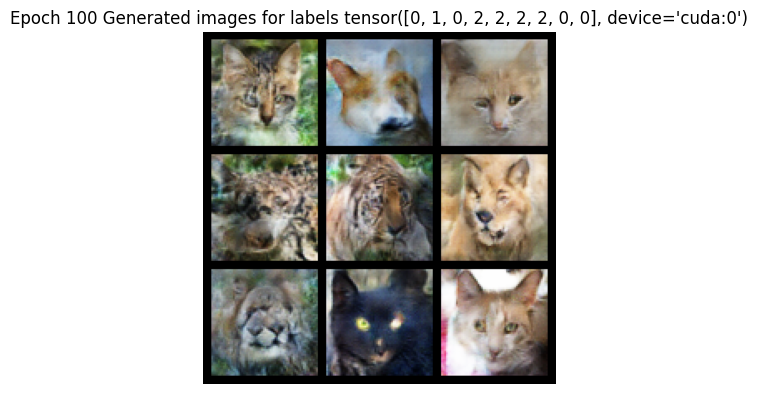

100%|██████████| 100/100 [46:13<00:00, 27.74s/it]

Training time: 2773.61s


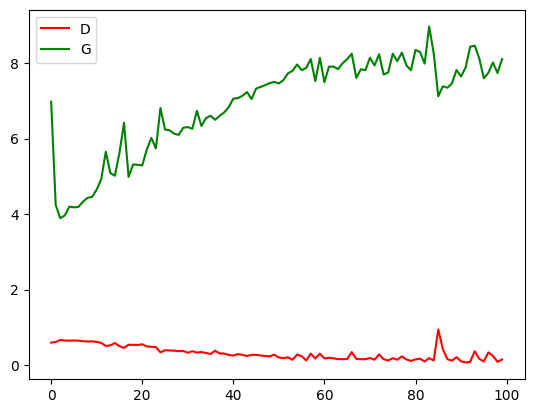

In [16]:
train_on_dataset('animals', animals_dataset)

In [ ]:
train_on_dataset('celeba', celeba_dataset)

100%|██████████| 791/791 [02:49<00:00,  4.66it/s]

  3%|▎         | 1/30 [02:49<1:22:01, 169.71s/it]

Discriminator loss for epoch 1 : 0.5443

Discriminator real loss for epoch 1 : 0.5594

Discriminator fake loss for epoch 1 : 0.5293

Generator loss for epoch 1 : 3.1843


100%|██████████| 791/791 [02:40<00:00,  4.94it/s]

  7%|▋         | 2/30 [05:29<1:16:32, 164.03s/it]

Discriminator loss for epoch 2 : 0.4706

Discriminator real loss for epoch 2 : 0.4862

Discriminator fake loss for epoch 2 : 0.4549

Generator loss for epoch 2 : 2.9897


100%|██████████| 791/791 [02:40<00:00,  4.94it/s]

 10%|█         | 3/30 [08:09<1:13:00, 162.25s/it]

Discriminator loss for epoch 3 : 0.3979

Discriminator real loss for epoch 3 : 0.4296

Discriminator fake loss for epoch 3 : 0.3662

Generator loss for epoch 3 : 3.4696


100%|██████████| 791/791 [02:41<00:00,  4.91it/s]

 13%|█▎        | 4/30 [10:51<1:10:07, 161.82s/it]

Discriminator loss for epoch 4 : 0.3306

Discriminator real loss for epoch 4 : 0.3528

Discriminator fake loss for epoch 4 : 0.3083

Generator loss for epoch 4 : 3.7975


100%|██████████| 791/791 [02:40<00:00,  4.94it/s]

 17%|█▋        | 5/30 [13:31<1:07:11, 161.25s/it]

Discriminator loss for epoch 5 : 0.3167

Discriminator real loss for epoch 5 : 0.3386

Discriminator fake loss for epoch 5 : 0.2948

Generator loss for epoch 5 : 3.7941


100%|██████████| 791/791 [02:40<00:00,  4.93it/s]

 20%|██        | 6/30 [16:11<1:04:24, 161.03s/it]

Discriminator loss for epoch 6 : 0.3038

Discriminator real loss for epoch 6 : 0.3210

Discriminator fake loss for epoch 6 : 0.2866

Generator loss for epoch 6 : 3.7278


100%|██████████| 791/791 [02:40<00:00,  4.94it/s]

 23%|██▎       | 7/30 [18:52<1:01:37, 160.77s/it]

Discriminator loss for epoch 7 : 0.2897

Discriminator real loss for epoch 7 : 0.3046

Discriminator fake loss for epoch 7 : 0.2748

Generator loss for epoch 7 : 3.7306


100%|██████████| 791/791 [02:40<00:00,  4.94it/s]

 27%|██▋       | 8/30 [21:32<58:53, 160.59s/it]  

Discriminator loss for epoch 8 : 0.2902

Discriminator real loss for epoch 8 : 0.3046

Discriminator fake loss for epoch 8 : 0.2759

Generator loss for epoch 8 : 3.6510


100%|██████████| 791/791 [02:39<00:00,  4.95it/s]

 30%|███       | 9/30 [24:12<56:08, 160.40s/it]

Discriminator loss for epoch 9 : 0.2892

Discriminator real loss for epoch 9 : 0.3070

Discriminator fake loss for epoch 9 : 0.2714

Generator loss for epoch 9 : 3.6159


 51%|█████▏    | 406/791 [01:22<01:17,  4.95it/s]